# TASK-1: Movie Audience Segmentation (Clustering)

**Goal:** Group movies into meaningful audience segments based on engagement and popularity so stakeholders can understand viewing behavior patterns.

---

## Step 1: Understand & Audit the Data

With small data, every feature matters. We need to check for missing values, range/scale differences, and skewed distributions before proceeding.

In [1]:
# ── Install Required Libraries ──
!pip install pandas numpy matplotlib seaborn scikit-learn

In [2]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

In [4]:
# Step 1: Load and Explore Dataset
df = pd.read_csv("../Dataset/original/movies.csv")
print("Dataset Shape:", df.shape)
print("\n--- First 5 Rows ---")
print(df.head())
print("\n--- Data Info ---")
print(df.info())
print("\n--- Statistical Summary ---")
print(df.describe())

Dataset Shape: (15, 6)

--- First 5 Rows ---
   movie_id  avg_watch_time  completion_rate  ratings_count  avg_rating  hit
0         1              45             0.60           1200         3.8    0
1         2             110             0.90           8500         4.6    1
2         3              60             0.65           2000         4.0    0
3         4             130             0.95          12000         4.8    1
4         5              40             0.55            900         3.6    0

--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         15 non-null     int64  
 1   avg_watch_time   15 non-null     int64  
 2   completion_rate  15 non-null     float64
 3   ratings_count    15 non-null     int64  
 4   avg_rating       15 non-null     float64
 5   hit              15 non-null     int64  
dtyp

In [5]:
# Check for missing values
print("Missing Values:")
print(df.isnull().sum())

Missing Values:
movie_id           0
avg_watch_time     0
completion_rate    0
ratings_count      0
avg_rating         0
hit                0
dtype: int64


In [6]:
# Step 2: Create Engagement & Popularity Features
# Objective: Group movies based on viewer engagement and popularity
# - Engagement = avg of normalized watch_time and completion_rate
# - Popularity = avg of normalized ratings_count and avg_rating
from sklearn.preprocessing import MinMaxScaler

features = ['avg_watch_time', 'completion_rate', 'ratings_count', 'avg_rating']
scaler_norm = MinMaxScaler()
df_norm = pd.DataFrame(scaler_norm.fit_transform(df[features]), columns=features)

# Create composite features
df['engagement'] = (df_norm['avg_watch_time'] + df_norm['completion_rate']) / 2
df['popularity'] = (df_norm['ratings_count'] + df_norm['avg_rating']) / 2

print("Created Engagement & Popularity features:")
print(df[['movie_id', 'engagement', 'popularity', 'hit']].head())

Created Engagement & Popularity features:
   movie_id  engagement  popularity  hit
0         1    0.080867    0.080201    0
1         2    0.725159    0.579365    1
2         3    0.207188    0.175021    0
3         4    0.874207    0.753133    1
4         5    0.000000    0.000000    0


In [7]:
# Step 3: Use Engagement and Popularity for Clustering
cluster_features = ['engagement', 'popularity']
X = df[cluster_features]

# Scale for K-Means
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Clustering Features:")
print(X.head())

Clustering Features:
   engagement  popularity
0    0.080867    0.080201
1    0.725159    0.579365
2    0.207188    0.175021
3    0.874207    0.753133
4    0.000000    0.000000


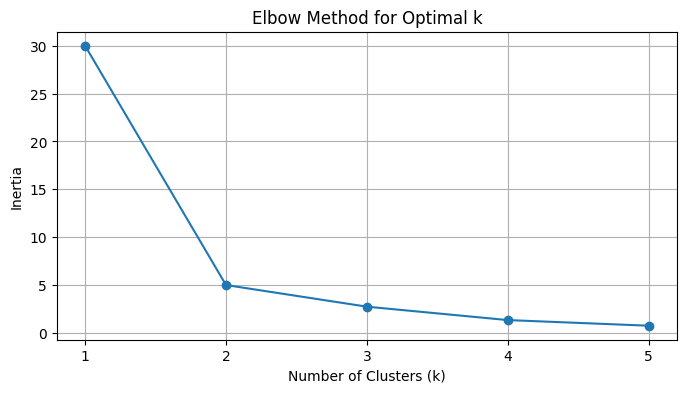

In [8]:
# Step 5: Decide Number of Clusters using Elbow Method
inertia = []
K_range = range(1, 6)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(K_range, inertia, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.xticks(K_range)
plt.grid(True)
plt.show()

# Based on elbow, k=2 shows significant drop

In [9]:
# Compare Silhouette Scores for k=2 and k=3
for k in [2, 3]:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    print(f"k={k}: Silhouette Score = {score:.4f}")

# Higher silhouette score = better cluster separation

k=2: Silhouette Score = 0.6880
k=3: Silhouette Score = 0.5733


In [10]:
# Step 4 & 6: Apply K-Means Clustering and Assign Labels
# Using k=2 based on elbow method and silhouette score
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(X_scaled)

print("Cluster Labels Assigned:")
print(df[['movie_id', 'cluster']])

Cluster Labels Assigned:


    movie_id  cluster
0          1        1
1          2        0
2          3        1
3          4        0
4          5        1
5          6        0
6          7        0
7          8        1
8          9        0
9         10        1
10        11        0
11        12        1
12        13        0
13        14        1
14        15        0


In [11]:
# Step 7: Interpret Clusters based on Engagement & Popularity
print("=== Cluster Summary (Engagement & Popularity) ===\n")
cluster_summary = df.groupby('cluster')[['engagement', 'popularity']].mean()
print(cluster_summary)

# Label clusters based on engagement/popularity
print("\n=== Cluster Interpretation ===")
for cluster_id in cluster_summary.index:
    eng = cluster_summary.loc[cluster_id, 'engagement']
    pop = cluster_summary.loc[cluster_id, 'popularity']
    if eng > 0.5 and pop > 0.5:
        label = 'Blockbusters (High Engagement & Popularity)'
    elif eng > 0.5 and pop <= 0.5:
        label = 'Cult Classics (High Engagement, Low Popularity)'
    elif eng <= 0.5 and pop > 0.5:
        label = 'Trending (Low Engagement, High Popularity)'
    else:
        label = 'Low Performers (Low Engagement & Popularity)'
    print(f"Cluster {cluster_id}: {label} (Eng: {eng:.3f}, Pop: {pop:.3f})")

=== Cluster Summary (Engagement & Popularity) ===

         engagement  popularity
cluster                        
0          0.815341    0.702590
1          0.164739    0.120659

=== Cluster Interpretation ===
Cluster 0: Blockbusters (High Engagement & Popularity) (Eng: 0.815, Pop: 0.703)
Cluster 1: Low Performers (Low Engagement & Popularity) (Eng: 0.165, Pop: 0.121)


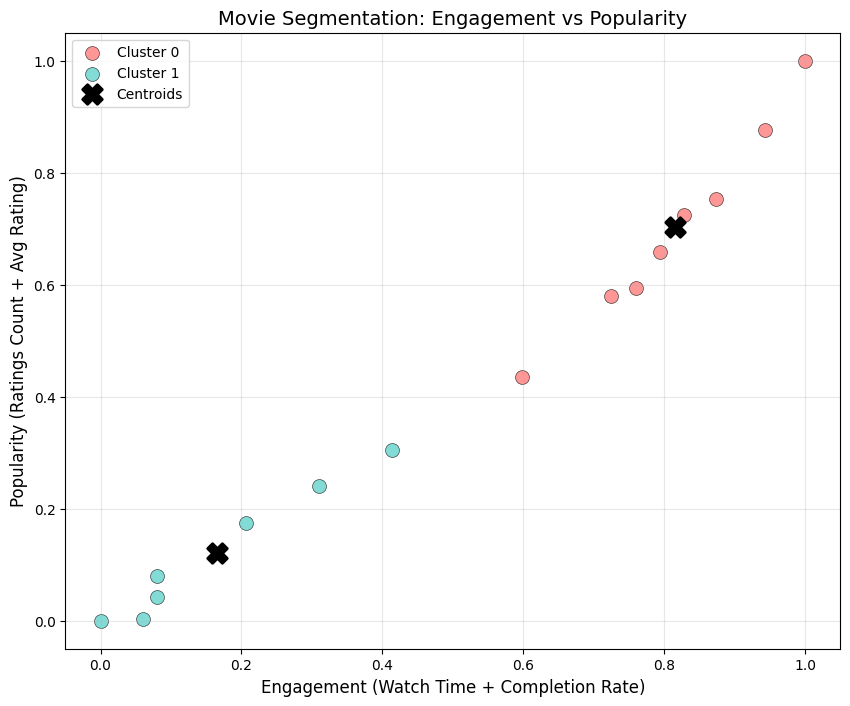

In [12]:
# Step 8: Visualize Clusters (Engagement vs Popularity)
# No PCA needed - we already have 2D features
plt.figure(figsize=(10, 8))
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

for cluster_id in sorted(df['cluster'].unique()):
    mask = df['cluster'] == cluster_id
    plt.scatter(df.loc[mask, 'engagement'], df.loc[mask, 'popularity'],
                c=colors[cluster_id], s=100, alpha=0.7,
                label=f'Cluster {cluster_id}', edgecolors='black', linewidth=0.5)

# Plot centroids
centers = scaler.inverse_transform(kmeans.cluster_centers_)
plt.scatter(centers[:, 0], centers[:, 1], c='black', marker='X',
            s=200, linewidth=2, label='Centroids')

plt.xlabel('Engagement (Watch Time + Completion Rate)', fontsize=12)
plt.ylabel('Popularity (Ratings Count + Avg Rating)', fontsize=12)
plt.title('Movie Segmentation: Engagement vs Popularity', fontsize=14)
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.show()

In [13]:
# Final Summary: Movies with Engagement & Popularity features
print("Final Dataset with Cluster Labels:\n")
print(df[['movie_id', 'engagement', 'popularity', 'hit', 'cluster']])

Final Dataset with Cluster Labels:

    movie_id  engagement  popularity  hit  cluster
0          1    0.080867    0.080201    0        1
1          2    0.725159    0.579365    1        0
2          3    0.207188    0.175021    0        1
3          4    0.874207    0.753133    1        0
4          5    0.000000    0.000000    0        1
5          6    0.793869    0.658939    1        0
6          7    0.598837    0.434837    1        0
7          8    0.080338    0.041562    0        1
8          9    0.942918    0.876566    1        0
9         10    0.310782    0.239975    0        1
10        11    0.759514    0.593985    1        0
11        12    0.059619    0.002924    0        1
12        13    0.828224    0.723893    1        0
13        14    0.414376    0.304929    0        1
14        15    1.000000    1.000000    1        0


In [14]:
# Final Silhouette Score for chosen clustering
final_score = silhouette_score(X_scaled, df['cluster'])
print(f"Final Silhouette Score (k=2): {final_score:.4f}")

Final Silhouette Score (k=2): 0.6880
